This notebook contains the code used in performing data exploration for the project.

In [10]:
#Import statements. Run this cell first.
import pandas as pd
import numpy as np
import snscrape.modules.twitter as snt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os, re, csv, pickle, sklearn, tqdm, spacy, nltk, gensim
from datetime import datetime
from scipy import stats
from nltk.corpus import stopwords
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from pprint import pprint

#nltk.download('stopwords')

In [11]:
def load_csv():
    columns = ["Tweet URL","Keywords","Account handle","Account type","Joined",
               "Following","Followers","Tweet Translated","Tweet NLP","Tweet Type",
               "Mentions Aquinos / Liberal Party","Mentions Aquinos / Liberal Party Negatively",
               "Date posted","Likes","Replies","Retweets","Quote Tweets","Retweets + Quote Tweets"]
    df = pd.read_csv("Dataset - Group 57 - Data.csv")[columns].dropna(subset=["Tweet URL"])
    return df

In [12]:
labels =     ["Following","Followers", "Mentions Aquinos / Liberal Party","Mentions Aquinos / Liberal Party Negatively",
               "Likes","Replies","Retweets","Quote Tweets","Retweets + Quote Tweets"]
df = load_csv()
###
for label in labels:
    print(f"{label} - all")
    ordf = df[label].sort_values().to_numpy()[:170]
    print(f"Size: {ordf.size}")
    print(f"Mean: {round(np.mean(ordf),6)}")
    print(f"Median: {round(np.median(ordf),6)}")
    print(f"Mode: {stats.mode(ordf)}")
    print(f"Range: [{np.min(ordf)}],[{np.max(ordf)}]")
    print(f"Sample Std. Dev: {round(np.std(ordf,ddof=1),6)}")
    print(f"\n{label} - reply")
    ordf2 = df[df['Tweet Type'].str.contains("Reply",na=False)][label].sort_values().to_numpy()[:170]
    print(f"Size: {ordf2.size}")
    print(f"Mean: {round(np.mean(ordf2),6)}")
    print(f"Median: {round(np.median(ordf2),6)}")
    print(f"Mode: {stats.mode(ordf2)}")
    print(f"Range: [{np.min(ordf2)}],[{np.max(ordf2)}]")
    print(f"Sample Std. Dev: {round(np.std(ordf2,ddof=1),6)}")
    print(f"\n{label} - non-reply")
    ordf3 = df[~df['Tweet Type'].str.contains("Reply",na=False)][label].sort_values().to_numpy()[:150]
    print(f"Size: {ordf3.size}")
    print(f"Mean: {round(np.mean(ordf3),6)}")
    print(f"Median: {round(np.median(ordf3),6)}")
    print(f"Mode: {stats.mode(ordf3)}")
    print(f"Range: [{np.min(ordf3)}],[{np.max(ordf3)}]")
    print(f"Sample Std. Dev: {round(np.std(ordf3,ddof=1),6)}")
    print("\n\n")
###

Following - all
Size: 170
Mean: 396.629412
Median: 96.0
Mode: ModeResult(mode=array([4], dtype=int64), count=array([4]))
Range: [0],[6455]
Sample Std. Dev: 856.795294

Following - reply
Size: 149
Mean: 402.731544
Median: 96.0
Mode: ModeResult(mode=array([4], dtype=int64), count=array([4]))
Range: [0],[6455]
Sample Std. Dev: 883.730404

Following - non-reply
Size: 21
Mean: 353.333333
Median: 108.0
Mode: ModeResult(mode=array([7], dtype=int64), count=array([2]))
Range: [7],[2636]
Sample Std. Dev: 649.335147



Followers - all
Size: 170
Mean: 435.841176
Median: 62.5
Mode: ModeResult(mode=array([0], dtype=int64), count=array([11]))
Range: [0],[10902]
Sample Std. Dev: 1262.19041

Followers - reply
Size: 149
Mean: 389.174497
Median: 47.0
Mode: ModeResult(mode=array([0], dtype=int64), count=array([11]))
Range: [0],[8390]
Sample Std. Dev: 1007.118439

Followers - non-reply
Size: 21
Mean: 766.952381
Median: 92.0
Mode: ModeResult(mode=array([3], dtype=int64), count=array([2]))
Range: [3],[10902]

C:\Users\Migui\AppData\Local\Temp\ipykernel_260\2497891256.py:11: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  print(f"Mode: {stats.mode(ordf)}")
C:\Users\Migui\AppData\Local\Temp\ipykernel_260\2497891256.py:19: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  print

In [13]:
df = load_csv()
#classify categories
libcat = [df['Mentions Aquinos / Liberal Party'][df['Mentions Aquinos / Liberal Party']==True].size,df['Mentions Aquinos / Liberal Party'][df['Mentions Aquinos / Liberal Party']==False].size]
date_posted = pd.to_datetime(df["Date posted"].str.strip(),format='%d/%m/%y %H:%M')
date_range = pd.to_datetime(pd.DataFrame({'year':[2021,2022],'month':[10,5],'day':[1,31]}))
mask = (date_posted >= date_range[0]) & (date_posted <= date_range[1])
bbmcat = [date_posted.loc[mask].size,date_posted.size-date_posted.loc[mask].size]
print("Chi-Square Test: Critical Value = 3.841, alpha = 0.05, df = 1")
print("Chi-Square: Mentions Liberal Party")
print(f"Yes: {libcat[0]} | No: {libcat[1]}")
print(stats.chisquare(f_obs = libcat,f_exp=[85,85]))
print("Chi-Square: Within BBM Campaign Period")
print(f"Yes: {bbmcat[0]} | No: {bbmcat[1]}")
print(stats.chisquare(f_obs = [103,67],f_exp=[16,154]))

Chi-Square Test: Critical Value = 3.841, alpha = 0.05, df = 1
Chi-Square: Mentions Liberal Party
Yes: 52 | No: 118
Power_divergenceResult(statistic=25.623529411764707, pvalue=4.149486677168825e-07)
Chi-Square: Within BBM Campaign Period
Yes: 103 | No: 67
Power_divergenceResult(statistic=522.2118506493507, pvalue=1.397418341452514e-115)


[0, 52, 93, 2, 0, 18, 69, 12, 90, 0, 29, 94, 83, 3, 29, 13, 58, 60, 1, 0, 9, 81, 142, 0, 150, 4, 0, 1, 0, 6, 5, 8, 8, 0, 93, 119, 83, 7, 58, 87, 49, 0, 82, 0, 0, 4, 8, 8, 0, 1, 3, 5, 103, 128, 1, 5, 1, 51, 7, 51, 8, 78, 86, 146, 52, 2, 2, 0, 3, 0, 3, 2, 1, 48, 2, 7, 50, 2, 1, 64, 2, 8, 10, 81, 7, 41, 4, 0, 3, 10, 86, 55, 43, 6, 117, 71, 35, 15, 15, 44, 4, 26, 96, 95, 7, 7, 16, 0, 1, 146, 81, 3, 86, 16, 40, 28, 3, 120, 18, 70, 6, 96, 3, 43, 26, 4, 20, 8, 1, 65, 21, 21, 3, 1, 89, 7, 7, 34, 3, 45, 175, 15, 125, 67, 88, 82, 0, 13, 8, 5, 9, 11, 16, 77, 0, 7, 7, 5, 1, 14, 12, 3, 10, 65, 3, 143, 120, 119, 1, 0]
10.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


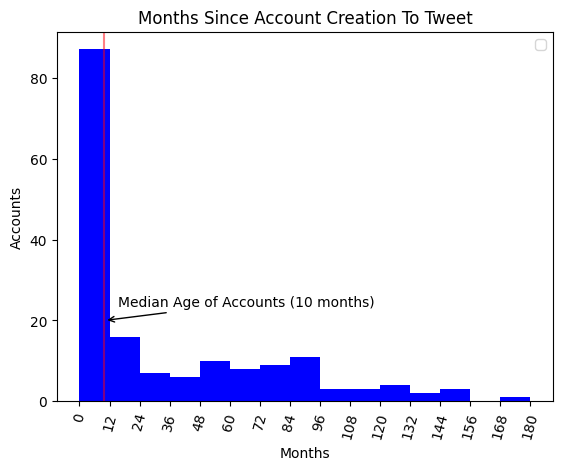

In [14]:
df = load_csv()
df = df.dropna(subset=["Tweet URL"])

#use this to filter Aquino/LP mentions
#df = df[df['Mentions Aquinos / Liberal Party']==True]

#get the date parameters
df["Joined"] = pd.to_datetime(df["Joined"].str.strip(),format='%m/%y')
df["Joined"] = df["Joined"].dt.to_period('m')
df["Date posted"] = pd.to_datetime(df["Date posted"].str.strip(),format='%d/%m/%y %H:%M')
df["Date posted"] = df["Date posted"].dt.to_period('m')

#get the time from last post to account creation
date_diff = (df["Date posted"].astype('int64').astype(int) - df["Joined"].astype('int64').astype(int)).tolist()
print(date_diff)

fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
#plot dates
#'''
plt.xlabel("Months")
plt.ylabel("Accounts")
diff_bins = np.arange(0,max(date_diff)+12,12)
plt.hist(date_diff,bins=diff_bins,color="blue")
print(np.median(date_diff))
plt.xticks(diff_bins,rotation=75)
plt.axvline(np.median(date_diff),alpha=0.5,color='#ff000d') #This marks the mean of the account ages relative to the date that the tweet was posted. Do not change the coordinates.
axes.annotate('Median Age of Accounts (10 months)', xy=(np.median(date_diff), 20), xytext=(10, 10),textcoords='offset points', arrowprops=dict(arrowstyle='->'))
plt.legend()
plt.title("Months Since Account Creation To Tweet")
plt.show()


[Period('2016-01', 'M'), Period('2022-12', 'M')]
Joined
2007-04    1
2009-02    1
2009-03    1
2009-07    3
2009-09    1
          ..
2022-02    4
2022-03    2
2022-04    1
2022-05    2
2022-08    1
Freq: M, Name: count, Length: 86, dtype: int64
Date posted
2007-01    NaN
2007-02    NaN
2007-03    NaN
2007-04    NaN
2007-05    NaN
          ... 
2022-08    2.0
2022-09    3.0
2022-10    2.0
2022-11    NaN
2022-12    1.0
Name: count, Length: 192, dtype: float64


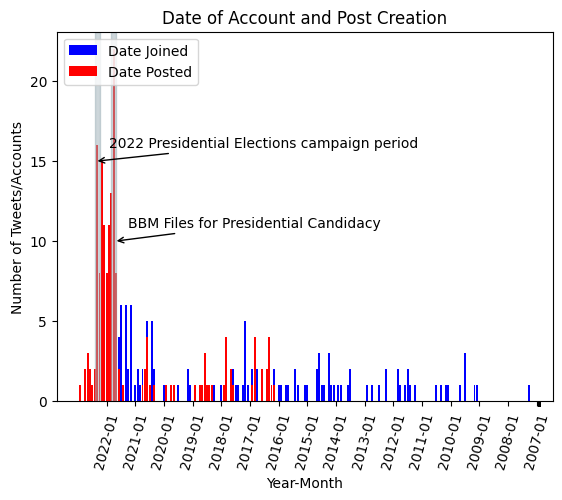

In [15]:
df = load_csv()
df = df.dropna(subset=["Tweet URL"])

#use this to filter Aquino/LP mentions
#df = df[df['Mentions Aquinos / Liberal Party']==True]

#get the date parameters
df["Joined"] = pd.to_datetime(df["Joined"].str.strip(),format='%m/%y')
df["Joined"] = df["Joined"].dt.to_period('m')
df["Date posted"] = pd.to_datetime(df["Date posted"].str.strip(),format='%d/%m/%y %H:%M')
df["Date posted"] = df["Date posted"].dt.to_period('m')

date_joined = df["Joined"].value_counts().sort_index()
date_posted = df["Date posted"].value_counts().sort_index()
month_range = [min(df["Joined"].min(),df["Date posted"].min()).asfreq('y','start').asfreq('m','start'),max(df["Joined"].max(),df["Date posted"].max()).asfreq('y','end').asfreq('m','end')]
print([(df["Date posted"].min()).asfreq('y','start').asfreq('m','start'),(df["Date posted"].max()).asfreq('y','end').asfreq('m','end')])

month_index = pd.period_range(start=month_range[0], end=month_range[1]).to_series().astype(str).tolist()
date_labels = ['']*len(month_index)
date_labels[::12] = [date for date in month_index[::12]]
print(date_joined)
date_joined = date_joined.reindex(month_index).sort_index()#.to_numpy(na_value=0)
date_posted = date_posted.reindex(month_index).sort_index()#.to_numpy(na_value=0)

date_joined.to_csv("aa.csv")
print(date_posted)
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
#plot dates
plt.xlabel("Year-Month")
plt.ylabel("Number of Tweets/Accounts")
plt.bar(month_index[::-1],date_joined[::-1],color="blue",label="Date Joined")
plt.bar(month_index[::-1],date_posted[::-1],color="red",label="Date Posted")
plt.xticks(date_labels[::-1],rotation=75)
plt.axvspan(6,8,alpha=0.5,color='#9CAFB7') #This marks the presidential elections period. Do not change the coordinates.
plt.axvspan(13,15,alpha=0.5,color='#9CAFB7') #This marks the start of the BBM presidential campaign. Do not change the coordinates.
axes.annotate('2022 Presidential Elections campaign period', xy=(6, 15), xytext=(10, 10),textcoords='offset points', arrowprops=dict(arrowstyle='->'))
axes.annotate('BBM Files for Presidential Candidacy', xy=(14, 10), xytext=(10, 10),textcoords='offset points', arrowprops=dict(arrowstyle='->'))
plt.legend()
plt.title("Date of Account and Post Creation")
plt.legend()
plt.show()


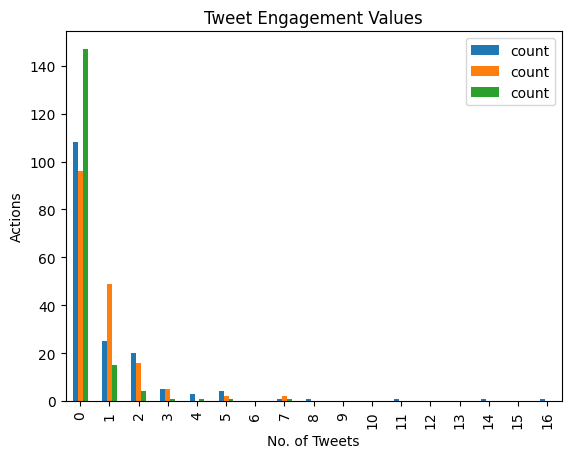

In [16]:
df = load_csv()
df = df.dropna(subset=["Tweet URL"])


#get the tweet parameters. retweets_count also includes quote tweets
likes_count = df["Likes"].value_counts().sort_index()
replies_count = df["Replies"].value_counts().sort_index()
retweets_count = df["Retweets + Quote Tweets"].value_counts().sort_index()
stats_range = [int(min(df["Likes"].min(),df["Replies"].min(),df["Retweets + Quote Tweets"].min())),int(max(df["Likes"].max(),df["Replies"].max(),df["Retweets + Quote Tweets"].max()))]
stats_index = [i for i in range(stats_range[0],stats_range[1]+1)]
likes_count = likes_count.reindex(stats_index).sort_index()#.to_numpy(na_value=0)
replies_count = replies_count.reindex(stats_index).sort_index()#.to_numpy(na_value=0)
retweets_count = retweets_count.reindex(stats_index).sort_index()#.to_numpy(na_value=0)

#get the number of tweets from the same user
tweets_count = df["Account handle"].value_counts().value_counts().sort_index()




df_stats = pd.concat([likes_count,replies_count,retweets_count],axis=1)
df_stats.plot.bar()
plt.xlabel("No. of Tweets")
plt.ylabel("Actions")

plt.title("Tweet Engagement Values")


plt.show()


### LDA Analysis

In [17]:

# Read data into papers
papers = pd.read_csv('Dataset - Group 57 - Data.csv')
# remove empty tweet translated
papers.dropna(axis=0,
    subset=["Tweet Translated"],
    inplace=True)
papers.shape

(170, 34)

In [18]:

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = papers["Tweet Translated"].values.tolist()
data_words = list(sent_to_words(data))

print(data_words[:1][0][:30])


['cases', 'against', 'the', 'marcos', 'family', 'was', 'filed', 'by', 'the', 'pcgg', 'but', 'all', 'of', 'these', 'was', 'won', 'by', 'the', 'marcoses', 'still', 'the', 'government', 'takes', 'their', 'wealth']


In [19]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [20]:
# NLTK Stop words


stop_words = stopwords.words('english')

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [21]:

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1][0][:30])

['case', 'family', 'file', 'pcgg', 'marcose', 'still', 'government', 'take', 'wealth']


In [22]:

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]


In [23]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10,
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [24]:

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.039*"case" + 0.019*"dismiss" + 0.016*"fact" + 0.016*"idiot" + '
  '0.011*"file" + 0.011*"court" + 0.011*"lp" + 0.011*"never" + 0.011*"reach" + '
  '0.011*"house"'),
 (1,
  '0.062*"case" + 0.047*"file" + 0.027*"know" + 0.022*"even" + '
  '0.016*"philippine" + 0.016*"thank" + 0.013*"century" + 0.012*"trial" + '
  '0.012*"marcose" + 0.011*"accusation"'),
 (2,
  '0.094*"case" + 0.027*"file" + 0.020*"marcose" + 0.020*"dismiss" + '
  '0.017*"court" + 0.016*"imelda" + 0.013*"even" + 0.013*"yet" + '
  '0.011*"evidence" + 0.011*"thief"'),
 (3,
  '0.086*"case" + 0.029*"marcose" + 0.022*"file" + 0.022*"wealth" + '
  '0.020*"prove" + 0.018*"dismiss" + 0.017*"court" + 0.014*"guilty" + '
  '0.014*"evidence" + 0.013*"imelda"'),
 (4,
  '0.037*"case" + 0.023*"marcose" + 0.023*"even" + 0.015*"criminal" + '
  '0.015*"show" + 0.015*"dismiss" + 0.015*"evidence" + 0.015*"proof" + '
  '0.008*"corrupt" + 0.008*"marco"'),
 (5,
  '0.067*"case" + 0.042*"dismiss" + 0.039*"evidence" + 0.026*"even" + '
  

In [25]:

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.2605941622247848


In [26]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):

    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k,
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)

    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')

    return coherence_model_lda.get_coherence()

In [27]:

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)),
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))

    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word,
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)

                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('./results/lda_tuning_results.csv', index=False)
    pbar.close()

 13%|█▎        | 69/540 [12:07<1:25:21, 10.87s/it]

In [ ]:
pd.DataFrame(model_results).to_csv('./results/lda_tuning_results.csv', index=False)

OSError: Cannot save file into a non-existent directory: 'results'